In [1]:
import pandas as pd
import seaborn as sns
import anndata
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}
gene_name_to_id_base = {v: k.split('.')[0] for k, v in gene_meta['gene_name'].items()}

id_base_to_name = {i.split('.')[0]: v for i, v in gene_meta['gene_name'].items()}

tf_genes = pd.read_csv(
    '/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv',
    index_col=0)
tf_genes = set(','.join(tf_genes['EnsemblID'].dropna()).split(','))
gene_meta['is_tf'] = gene_meta.index.map(lambda i: i.split('.')[0] in tf_genes)

zfp_pattern = r'Zfp\d+'
p = re.compile(zfp_pattern)
gene_meta.loc[gene_meta['gene_name'].apply(lambda i: p.search(i) is not None), 'is_tf'] = True
tf_gene_names = set(gene_meta[gene_meta['is_tf']]['gene_name'].tolist())

motif_anno = pd.read_csv(
    '/home/hanliu/ref/MEME/selected_motifs_sets/JASPAR2020_CORE_vertebrates_non-redundant.mouse_genes.csv',
    index_col='motif_uid')

In [3]:
clusters = [
    'CGE-Lamp5', 'CGE-Vip', 'CT-L6', 'IT-L23', 'IT-L4', 'IT-L5', 'IT-L6',
    'L6b', 'MGE-Pvalb', 'MGE-Sst', 'NP-L6', 'PT-L5'
]

In [4]:
cluster_map = {
    'Lamp5': 'CGE-Lamp5',
    'Vip': 'CGE-Vip',
    'Pvalb': 'MGE-Pvalb',
    'Sst': 'MGE-Sst',
    'L6 CT': 'CT-L6',
    'L2/3 IT': 'IT-L23',
    'L4/5 IT': 'IT-L4',
    'L5 IT': 'IT-L5',
    'L6 IT': 'IT-L6',
    'L6b': 'L6b',
    'L5/6 NP': 'NP-L6',
    'L5 PT': 'PT-L5'
}

mc_to_rna_cluster = {v:k for k, v in cluster_map.items()}

In [5]:
lgp_cutoff = 3
odds_cutoff = 1

## get pairs

In [6]:
rna_df = pd.read_csv('./RNA_cell/Total_one_vs_rest_deg.tf_only.csv.gz', index_col=0)
rna_df['gene_name'] = rna_df['ensembl_id'].map(id_base_to_name)

In [7]:
# rna_df = rna_df[(rna_df['log2fc'] > 1.5) & (rna_df['adjp'] < 1e-5)]

In [8]:
motif_df = pd.read_csv('./DMR/Total_one_vs_rest.motifs.csv.gz', index_col=0)
motif_df = pd.concat([motif_df, motif_anno.reindex(motif_df.index)], axis=1)
motif_df = motif_df[~motif_df['gene_ids'].isna()].copy()
motif_df['sig'] = (motif_df['-lgp'] > lgp_cutoff) & (motif_df['oddsratio'] > odds_cutoff)

In [9]:
def get_top(gene, motif_df):
    _sel = motif_df[motif_df['gene_names'].apply(lambda i: gene in i)]
    if _sel.shape[0] == 0:
        return pd.Series({'adj_p': np.NaN, 'oddsratio': np.NaN, 'sig': False})
    else:
        return _sel.sort_values('adj_p').iloc[0].loc[['adj_p', 'oddsratio', 'sig']]

In [10]:
rna_clusters = ['L6 CT', 'L6b', 'L6 IT', 'L5 IT', 'L2/3 IT', 'Lamp5', 'L5 PT',
       'L4/5 IT', 'Pvalb', 'L5/6 NP', 'Vip', 'Sst']

mc_clusters = [cluster_map[c] for c in rna_clusters]

In [11]:
total_data = []
for rna_cluster in rna_clusters:
    mc_cluster = cluster_map[rna_cluster]
    
    rna_cluster_df = rna_df[rna_df['cluster'] == rna_cluster]
    motif_cluster_df = motif_df[motif_df['cluster'] == mc_cluster]
    
    def get_top(gene):
        _sel = motif_cluster_df[motif_cluster_df['gene_names'].apply(lambda i: gene in i)]
        if _sel.shape[0] == 0:
            return pd.Series({'adj_p': np.NaN, 'oddsratio': np.NaN, 'sig': False})
        else:
            return _sel.sort_values('adj_p').iloc[0].loc[['adj_p', 'oddsratio', 'sig']]
    
    rna_cluster_df_with_motif = pd.concat([
        rna_cluster_df[['gene_name', 'log2fc', 'adjp']],
        rna_cluster_df['gene_name'].apply(get_top)
    ],
                                       axis=1)
    # change sign because I want to use cmap
    rna_cluster_df_with_motif['log2OR'] = np.log2(rna_cluster_df_with_motif['oddsratio'])
    rna_cluster_df_with_motif['Exp. -lgP'] = -np.log10(rna_cluster_df_with_motif['adjp'])
    rna_cluster_df_with_motif['Motif -lgP'] = -np.log10(rna_cluster_df_with_motif['adj_p'])
    
    rna_cluster_df_with_motif = rna_cluster_df_with_motif[~rna_cluster_df_with_motif['sig'].isna()]
    rna_cluster_df_with_motif['Cluster'] = rna_cluster
    total_data.append(rna_cluster_df_with_motif)
    
total_data = pd.concat(total_data)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Plot

In [12]:
gene_names = [
    'Dlx6', 'Dlx5', 'Dlx2', 'Dlx1', 'Sox2', 'Sox1', 'Arx', 'Nr3c2', 'Arid5a',
    'Maf', 'Mafb', 'Lhx6', 'Rarb', 'Ets1', 'Esr1', 'Esrrg', 'Esrrb', 'Esrra',
    'Pparg', 'Bach1', 'Nfix', 'Nfib', 'Nfia', 'Etv1', 'Bhlhe22', 'Ascl1',
    'Zeb1', 'Pou3f4', 'Pou3f3', 'Pou3f2', 'Pou3f1', 'Egr4', 'Egr3', 'Egr2',
    'Egr1', 'Klf10', 'Fosl2', 'Twist2', 'Rora', 'Rorb', 'Atoh7', 'Neurod1',
    'Rfx3', 'Rreb1'
]

gene_ids = [gene_name_to_id_base[g] for g in gene_names]

In [13]:
rna_adata = anndata.read_h5ad('RNA_cell/RNA.cpm.log1p.h5ad')
rna_adata = rna_adata[:, rna_adata.var['ensembl_id'] != '']
rna_data = pd.DataFrame(rna_adata.X, index=rna_adata.obs_names, columns=rna_adata.var['ensembl_id'].astype(str))
use_rna_data = rna_data.loc[:, gene_ids]
use_rna_data.to_csv('use_rna_data.csv.gz')

In [17]:
use_rna_data = pd.read_csv('use_rna_data.csv.gz', index_col=0)

In [21]:
size_data = use_rna_data.groupby(rna_adata.obs['cluster']).apply(
    lambda i: (i>0).sum(axis=0) / i.shape[0]).unstack()  # the protion of cell expressed
hue_data = use_rna_data.groupby(rna_adata.obs['cluster']).apply(
    lambda i: i.apply(lambda j: j[j>0].mean())).unstack()  # the mean in cell expressed
plot_data = pd.DataFrame({'rna_size': size_data, 'rna_hue': hue_data})

In [22]:
_motif_df = motif_df.copy()
_motif_df['ensembl_id'] = _motif_df['gene_ids'].str.split('.').str[0]
_motif_df['cluster'] = _motif_df['cluster'].map(
    {v: k
     for k, v in cluster_map.items()})

_motif_df['log2or'] = np.log2(_motif_df['oddsratio'])
motif_plot_data = _motif_df.reset_index().set_index(['ensembl_id', 'cluster'
                                                     ])[['log2or', '-lgp']]

records = {}
for index, sub_df in motif_plot_data.groupby(motif_plot_data.index):
    records[index] = sub_df.sort_values('-lgp').iloc[-1]
    
motif_plot_data = pd.DataFrame(records).T
motif_plot_data.index.name = ['ensembl_id', 'cluster']
motif_plot_data.columns = ['motif_hue', 'motif_size']

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
plot_data = pd.concat([plot_data, motif_plot_data.loc[plot_data.index]], axis=1).dropna(how='any')
plot_data = plot_data.replace(np.inf, 10)
plot_data = plot_data.reset_index()
plot_data['gene_name'] = plot_data['ensembl_id'].map({k.split('.')[0]:v 
                                                      for k, v in gene_meta['gene_name'].items()})

In [24]:
plot_data['rna_hue_norm'] = plot_data.groupby('gene_name')['rna_hue'].apply(lambda i: i / i.max())

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


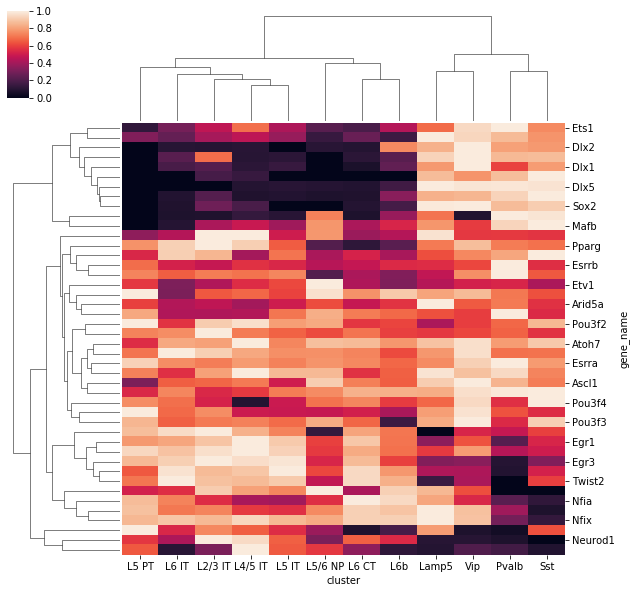

In [25]:
rna_hue_mat = plot_data.pivot(index='gene_name', columns='cluster', values='rna_hue_norm').fillna(0)

g = sns.clustermap(rna_hue_mat)
gene_order = g.dendrogram_row.dendrogram['leaves']
gene_order = {k:v for k, v in zip(rna_hue_mat.index, gene_order)}
cluster_order = g.dendrogram_col.dendrogram['leaves']
cluster_order = {k:v for k, v in zip(rna_hue_mat.columns, cluster_order)}

In [28]:
gene_order = gene_names

cluster_order = [
    'L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT', 'L5 PT', 'L6 CT', 'L5/6 NP', 'L6b', 'Pvalb', 'Sst', 'Vip', 'Lamp5'
]


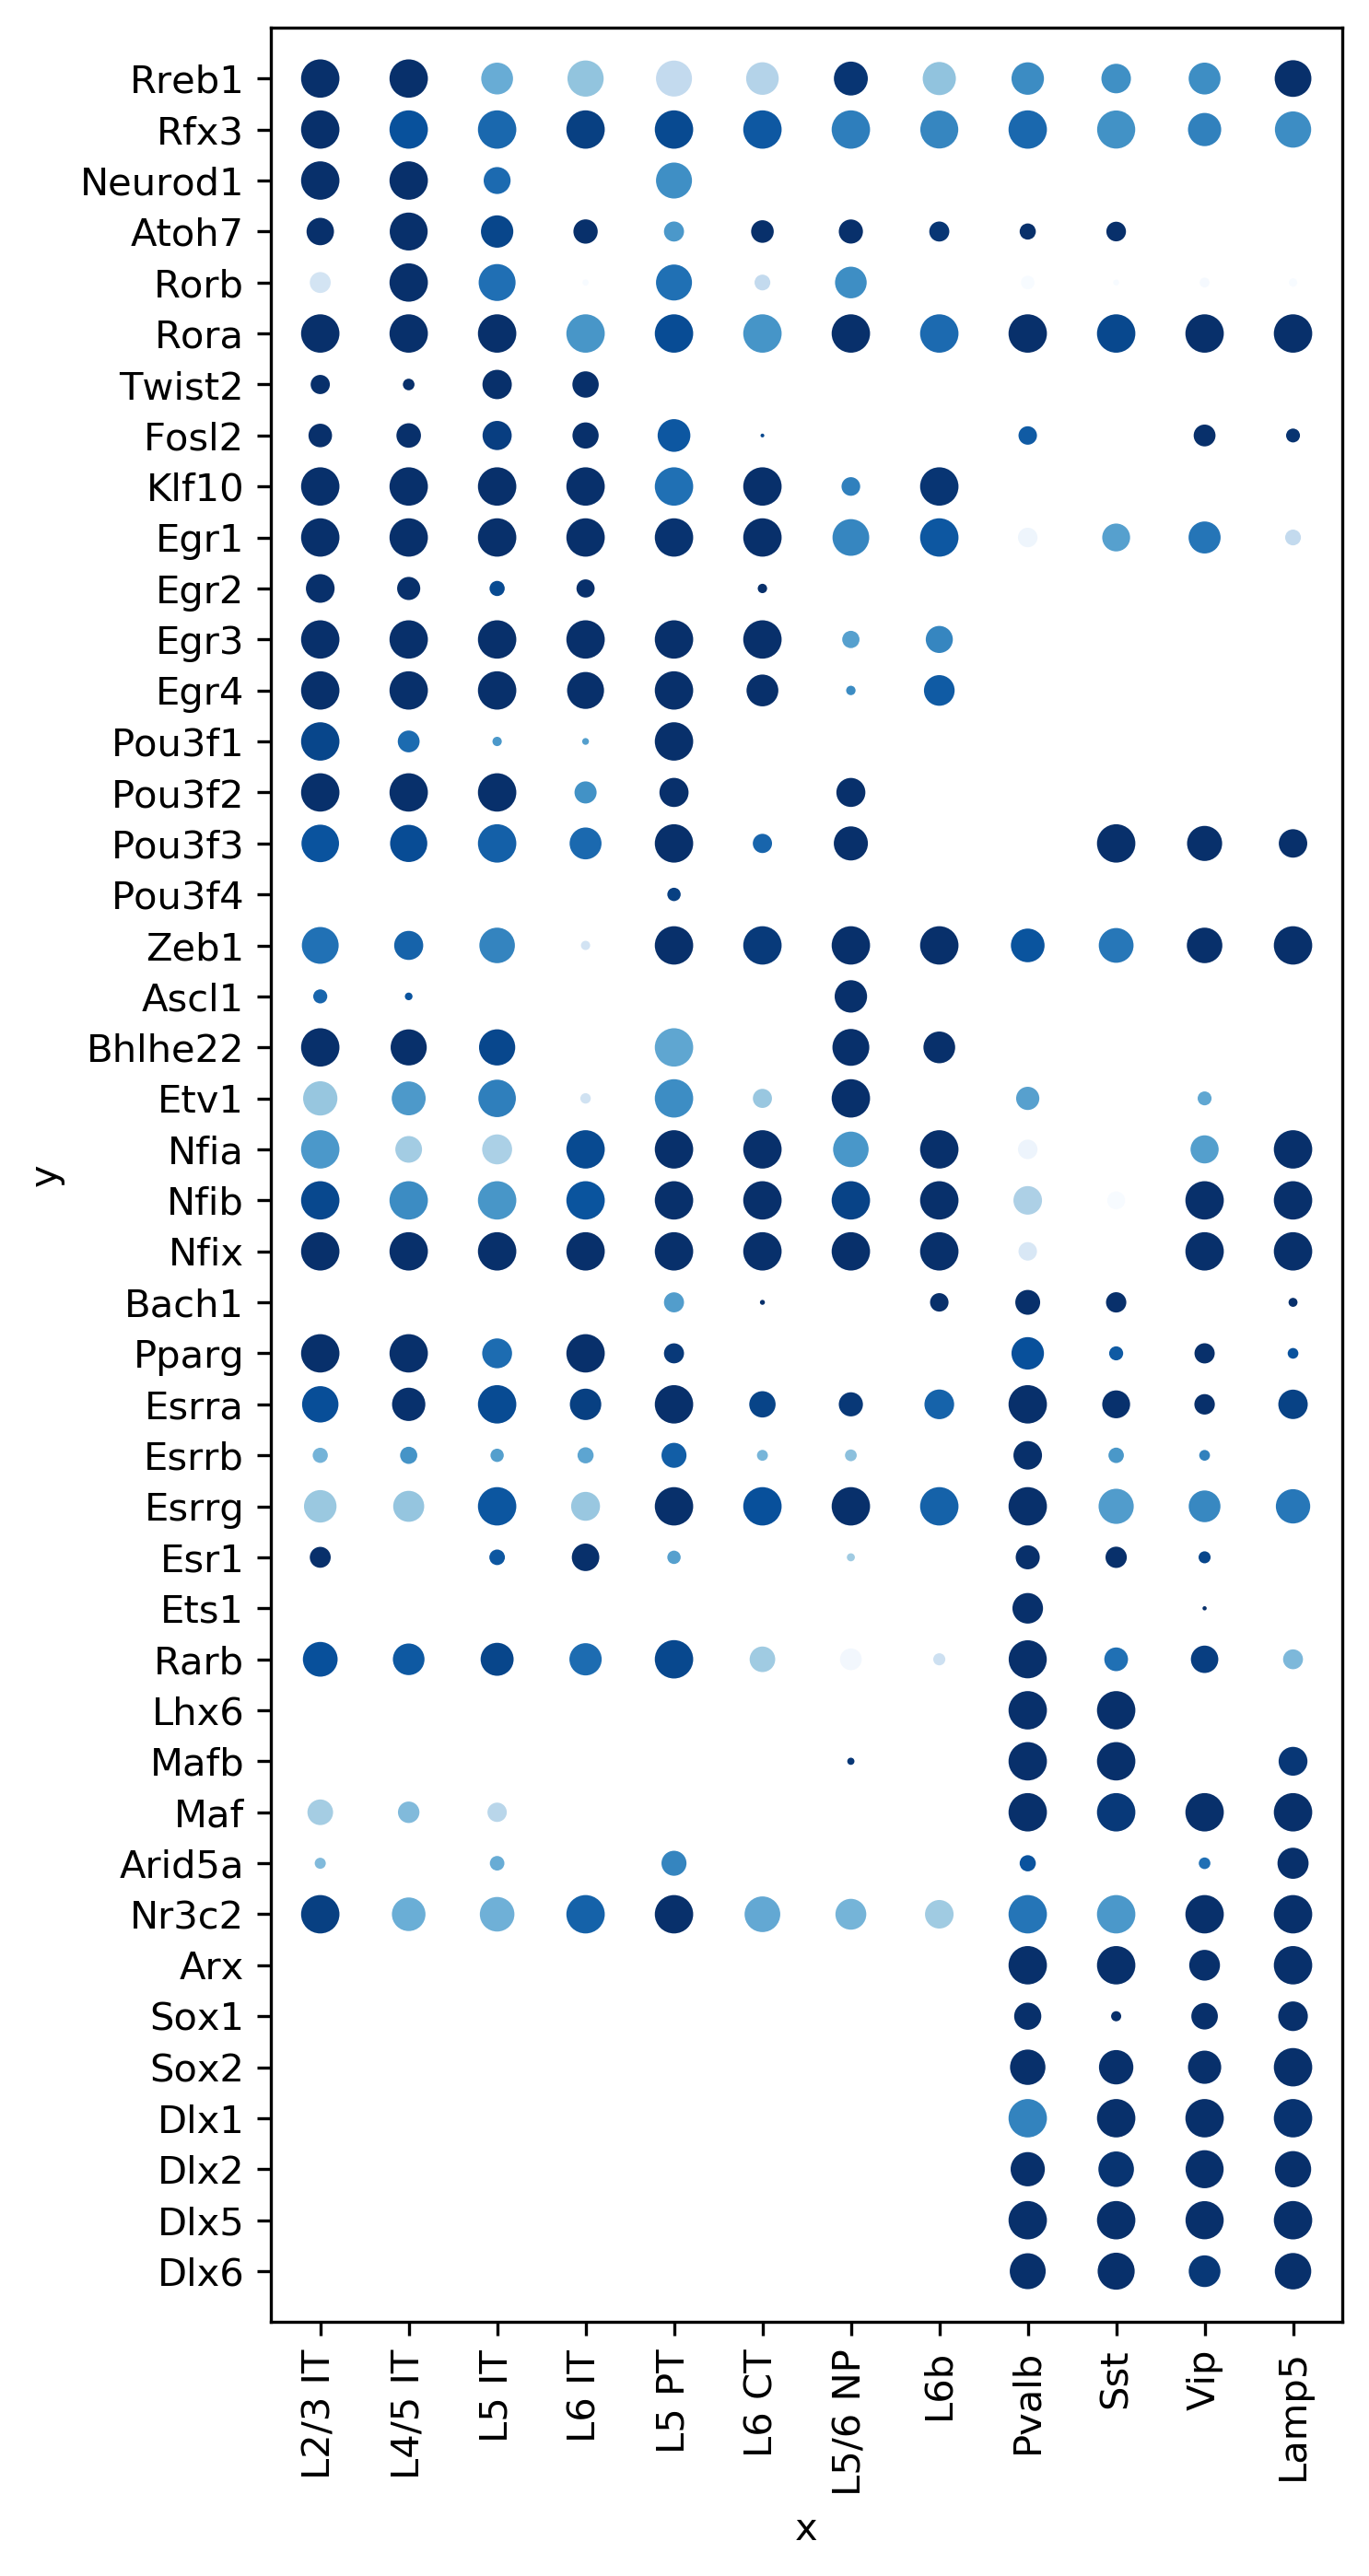

In [29]:
fig, ax = plt.subplots(figsize=(5, len(gene_order) / 4), dpi=300)

_plot_data = plot_data[plot_data['gene_name'].isin(gene_order)].copy()
_plot_data['x'] = _plot_data['cluster'].apply(lambda i: cluster_order.index(i))
_plot_data['y'] = _plot_data['gene_name'].apply(lambda i: gene_order.index(i))

sns.scatterplot(x='x', y='y', data=_plot_data,
                hue='rna_hue_norm', hue_norm=(0.2, 0.8), palette='Blues',
                size='rna_size', sizes=(0, 100), size_norm=(0.2, 0.8),
                linewidth=0, legend=None)
ax.set(ylim=(-1, len(gene_order)), 
       xticks=range(len(cluster_order)), xticklabels=cluster_order,
       yticks=range(len(gene_order)), yticklabels=gene_order)
ax.xaxis.set_tick_params(rotation=90)
pass

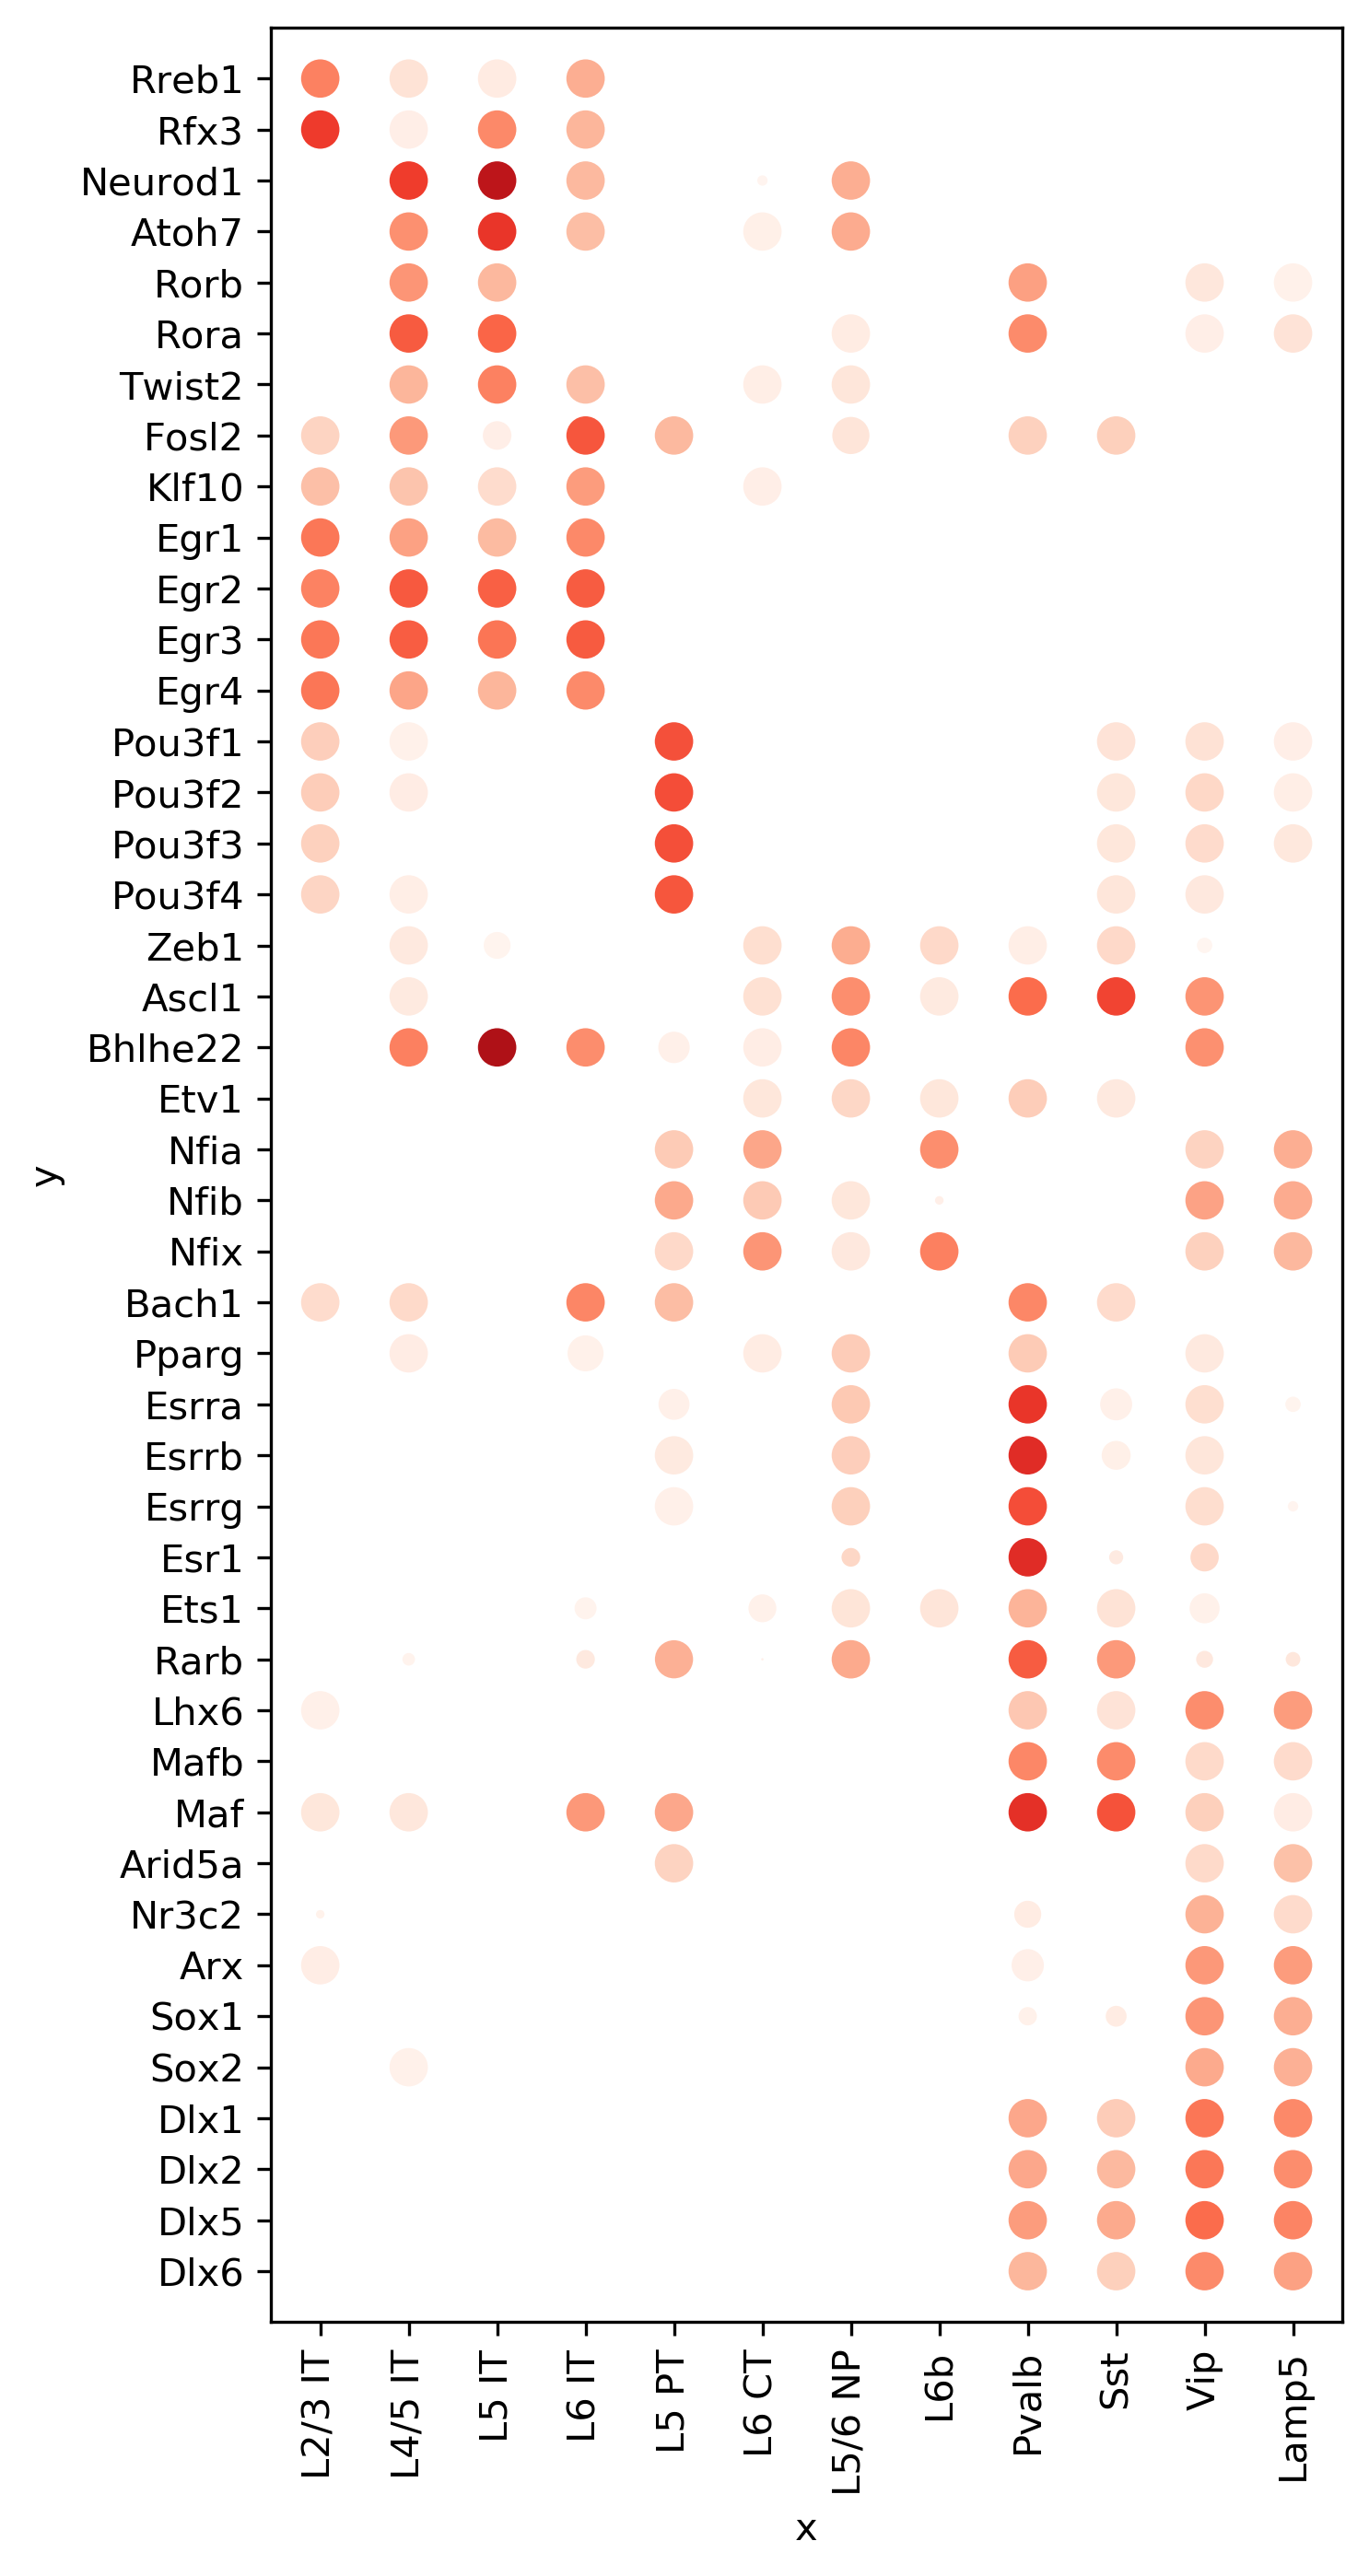

In [30]:
fig, ax = plt.subplots(figsize=(5, len(gene_order) / 4), dpi=300)

_plot_data = plot_data[plot_data['gene_name'].isin(gene_order)].copy()
_plot_data['x'] = _plot_data['cluster'].apply(lambda i: cluster_order.index(i))
_plot_data['y'] = _plot_data['gene_name'].apply(lambda i: gene_order.index(i))

sns.scatterplot(x='x', y='y', data=_plot_data,
                hue='motif_hue', hue_norm=(0, 2), palette='Reds',
                size='motif_size', sizes=(0, 100), size_norm=(0, 1),
                linewidth=0, legend=None)
ax.set(ylim=(-1, len(gene_order)), 
       xticks=range(len(cluster_order)), xticklabels=cluster_order,
       yticks=range(len(gene_order)), yticklabels=gene_order)
ax.xaxis.set_tick_params(rotation=90)
pass

In [45]:
gene_order = [
    'Rreb1', 'Rfx3', 'Neurod1', 'Atoh7', 'Rorb', 'Rora', 'Twist2', 'Fosl2',
    'Klf10', 'Egr1', 'Egr2', 'Egr3', 'Egr4', 'Pou3f1', 'Pou3f2', 'Pou3f3',
    'Pou3f4', 'Zeb1', 'Ascl1', 'Bhlhe22', 'Etv1', 'Nfia', 'Nfib', 'Nfix',
    'Dlx1', 'Dlx2', 'Dlx5', 'Dlx6', 'Bach1', 'Pparg', 'Esrra', 'Esrrb',
    'Esrrg', 'Esr1', 'Ets1', 'Rarb', 'Lhx6', 'Mafb', 'Maf', 'Arid5a', 'Nr3c2',
    'Arx', 'Sox1', 'Sox2'
]
gene_labels = [
    'Rreb1 (L2/3 IT)', 'Rfx3 (L2/3 IT)', 'Neurod1 (L4/5 IT)',
    'Atoh7 (L4/5 IT)', 'Rorb (L4/5 IT)', 'Rora (L4/5 IT, Pvalb)',
    'Twist2 (L5/6 IT)', 'Fosl2 (L6 IT)', 'Klf10 (IT)', 'Egr1 (IT)',
    'Egr2 (IT)', 'Egr3 (IT)', 'Egr4 (IT)', 'Pou3f1 (L5 ET)', 'Pou3f2 (L5 ET)',
    'Pou3f3 (L5 ET)', 'Pou3f4 (L5 ET)', 'Zeb1 (NP)', 'Ascl1 (NP)',
    'Bhlhe22 (NP, L4/5 IT)', 'Etv1 (NP)', 'Nfia (CGE, L6b)', 'Nfib (CGE, L6b)',
    'Nfix (CGE, L6b)', 'Dlx1 (In)', 'Dlx2 (In)', 'Dlx5 (In)', 'Dlx6 (In)',
    'Bach1 (Pvalb)', 'Pparg (Pvalb)', 'Esrra (Pvalb)', 'Esrrb (Pvalb)',
    'Esrrg (Pvalb)', 'Esr1 (Pvalb)', 'Ets1 (Pvalb)', 'Rarb (Pvalb)',
    'Lhx6 (MGE?)', 'Mafb (MGE)', 'Maf (MGE)', 'Arid5a (Lamp5)', 'Nr3c2 (CGE)',
    'Arx (CGE)', 'Sox1 (CGE)', 'Sox2 (CGE)'
]
cluster_order = [
    'L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT', 'L5 PT', 'L6 CT', 'L5/6 NP', 'L6b',
    'Pvalb', 'Sst', 'Vip', 'Lamp5'
]

cluster_labels = [
    'L2/3 IT', 'L4/5 IT', 'L5 IT', 'L6 IT', 'L5 ET', 'L6 CT', 'L5/6 NP', 'L6b',
    'Pvalb', 'Sst', 'Vip', 'Lamp5'
]

In [ ]:
fig, ax = plt.subplots(figsize=(5, len(gene_order) / 3.2), dpi=300)

_plot_data = plot_data[plot_data['gene_name'].isin(gene_order)].copy()
_plot_data['x'] = _plot_data['cluster'].apply(lambda i: cluster_order.index(i))
_plot_data['y'] = _plot_data['gene_name'].apply(lambda i: gene_order.index(i)*2+0.1)

_motif_plot_data = plot_data[plot_data['gene_name'].isin(gene_order)].copy()
_motif_plot_data['x'] = _motif_plot_data['cluster'].apply(lambda i: cluster_order.index(i))
_motif_plot_data['y'] = _motif_plot_data['gene_name'].apply(lambda i: gene_order.index(i)*2+0.9)


sns.scatterplot(x='x', y='y', data=_plot_data,
                hue='rna_hue_norm', hue_norm=(0.5, 1), palette='Blues',
                size='rna_size', sizes=(0, 60), size_norm=(0., 1),
                linewidth=0, legend=None)

sns.scatterplot(x='x', y='y', data=_motif_plot_data,
                hue='motif_hue', hue_norm=(0, 2), palette='Reds',
                size='motif_size', sizes=(0, 60), size_norm=(0, 1),
                linewidth=0, legend=None)

ax.set(ylim=(-0.55, len(gene_order)*2-0.45), 
       xlim=(-0.5, len(cluster_order)),
       xlabel='', ylabel='',
       xticks=range(len(cluster_order)), xticklabels=cluster_labels,
       yticks=[y+0.5 for y in range(0, len(gene_order)*2, 2)], yticklabels=gene_labels)
ax.xaxis.set_tick_params(rotation=90)

for y in range(0, len(gene_order)*2, 2):
    ax.plot((-0.5, len(cluster_order)-0.5), (y+0.5, y+0.5), c='lightgray', linewidth=0.5, linestyle='--')
    ax.plot((-0.5, len(cluster_order)-0.5), (y-0.5, y-0.5), c='gray', linewidth=0.5)
    ax.plot((-0.5, len(cluster_order)-0.5), (y+1.5, y+1.5), c='gray', linewidth=0.5)

for i in range(0, len(cluster_order), 2):
    ax.axvspan(i-0.5, i+0.5, color='lightgray', alpha=0.15, zorder=-100, lw=0)
sns.despine(ax=ax, offset=0, left=True, bottom=True)

fig.savefig('TFPlot.cell_final.pdf')